# Bearing Sensor Data

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.fft import fft
from scipy.fft import rfft
from scipy import signal
from scipy.signal import spectrogram

In [3]:
data_path = "IMS/3rd_test/4th_test/txt"
all_files = os.listdir(data_path)
sensor_col_names = [f'bearing_{i}' for i in range(1,5)]
all_dfs = []
for file_name in all_files:
    df = pd.read_csv(os.path.join(data_path, file_name), sep='\t', names=sensor_col_names)
    all_dfs.append(df)
    
all_dfs[0].head()

,bearing_1,bearing_2,bearing_3,bearing_4
0,-0.115,-0.056,-0.027,0.029
1,-0.029,0.046,-0.044,0.168
2,-0.010,0.024,-0.010,0.146
3,-0.044,-0.022,-0.098,0.039
4,-0.005,-0.073,-0.166,0.024


## Spectrograms for all_dfs

In [7]:
# # # # Directory to save spectrogram images
# # # output_dir = 'spectrogram_data2'

# # # # Create directory if it doesn't exist
# # # os.makedirs(output_dir, exist_ok=True)

# Define parameters for STFT
window_size = 256  # Size of the window for STFT
overlap = 0.5  # Overlap between consecutive windows

# Iterate over each dataset
for df_index, df in enumerate(all_dfs, start=1):
    # Iterate over bearings
    for bearing_index in range(1, 5):
        # Get signal data from respective column
        signal = df[f'bearing_{bearing_index}'].values
        
        # Compute spectrogram
        freqs, times, Sxx = spectrogram(signal, fs=1, window='hann', nperseg=window_size, noverlap=int(window_size*overlap))
        
        # Plotting the spectrogram
        plt.figure(figsize=(2, 2))
        plt.pcolormesh(times, freqs, 10 * np.log10(Sxx), shading='gouraud', cmap='plasma', vmin=-60, vmax=0)
        # plt.tight_layout()
        plt.axis('off')
        
        # Save the plot as an image
        plt.savefig(f'spectrogram_DS3/spectrogram_{df_index}_bearing{bearing_index}.png', bbox_inches='tight', pad_inches=0)
        
        # Close the current plot to release memory
        plt.close()

## Importing the Spectrograms into a dataset

In [9]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

# Define directories containing spectrogram images
image_dir = 'spectrogram_DS3'

batch_size = 1

images = image_dataset_from_directory(
    directory=image_dir,
    labels=None,
    image_size=(140, 119),
    batch_size=batch_size,
    subset=None,
    shuffle=True)

filenames = images.file_paths

# num_images = len(images.filenames)
# print(f"Number of images: {num_images}")

num_batches = len(images)
print(f"Number of batches: {num_batches}")

# Get the first batch of data from the dataset
first_batch = next(iter(images))

# Access the first image within the first batch
first_image = first_batch[0]

# Print the shape of the first image
print("Shape of the first image:", first_image.shape)

Found 25296 files belonging to 1 classes.
Number of batches: 25296
Shape of the first image: (140, 119, 3)


### Taking the first 1000 images (the first 250s of each bearing) and the last 1000 images of the dataset

In [10]:
num_images = len(images)
x_train = list(images.take(1000).as_numpy_iterator())
x_test = list(images.skip(num_images-1000).as_numpy_iterator())

# Autoencoders

## Basic Autoencoder

https://blog.keras.io/building-autoencoders-in-keras.html

In [11]:
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

input_img = Input(shape=(np.prod([140, 119, 3]),))  # assuming RGB images
# input_img = Input(shape=(np.prod([256, 256, 3]),))

encoder_dim = 1024

# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoder_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(np.prod([140, 119, 3]), activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# This model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# This is our encoded (32-dimensional) input
encoded_input = Input(shape=(encoder_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

optimizers.Adam(
    learning_rate=0.01,
    name="adam")

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [12]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49980)]           0         
                                                                 
 dense (Dense)               (None, 1024)              51180544  
                                                                 
 dense_1 (Dense)             (None, 49980)             51229500  
                                                                 
Total params: 102,410,044
Trainable params: 102,410,044
Non-trainable params: 0
_________________________________________________________________


In [13]:
from sklearn.model_selection import train_test_split

# images_list = list(images.as_numpy_iterator())

# x_train, x_test = train_test_split(images_list, test_size=0.2, random_state=42)

x_train = np.array(x_train)/ 255.
x_test = np.array(x_test)/ 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(1000, 49980)
(1000, 49980)


In [14]:
from tensorflow.keras import callbacks

lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=0.001)

es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[lr, es])

Epoch 1/100
32/32 [==============================] - 4s 120ms/step - loss: 0.5975 - val_loss: 0.5827 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 4s 114ms/step - loss: 0.5807 - val_loss: 0.5797 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 4s 116ms/step - loss: 0.5797 - val_loss: 0.5789 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 4s 120ms/step - loss: 0.5781 - val_loss: 0.5773 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 4s 123ms/step - loss: 0.5772 - val_loss: 0.5770 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 4s 119ms/step - loss: 0.5771 - val_loss: 0.5770 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 4s 117ms/step - loss: 0.5782 - val_loss: 0.5780 - lr: 0.0010
Epoch 8/100
32/32 [==============================] - 4s 119ms/step - loss: 0.5772 - val_loss: 0.5768 - lr: 0.0010
Epoch 9/100
32/32 [==============================] - 4s 118ms/step - loss: 0.5769 - val_

In [10]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

32/32 [==============================] - 0s 9ms/step


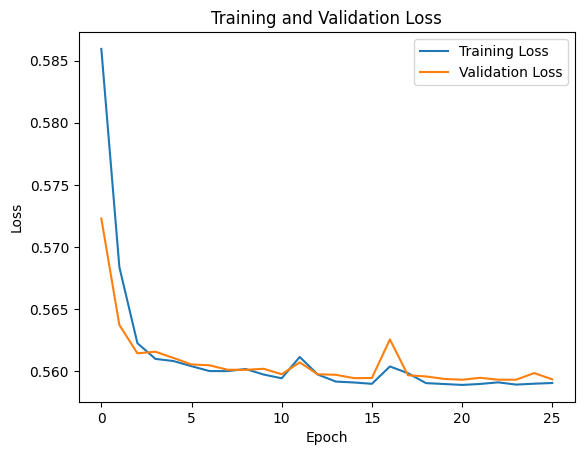

In [11]:
history = autoencoder.history

# Plot the loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

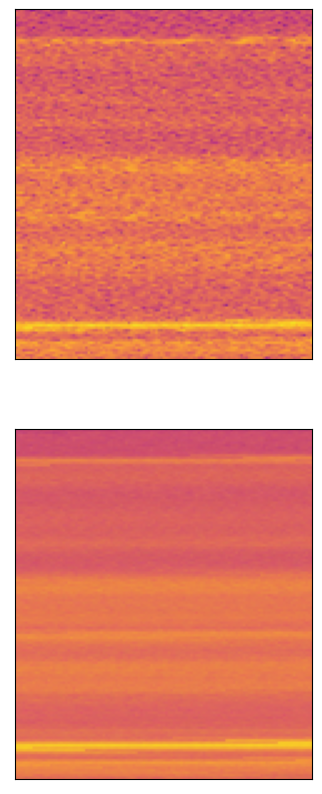

In [12]:
import matplotlib.pyplot as plt

n = 1  # How many digits we will display
plt.figure(figsize=(10, 10))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(140, 119, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(140, 119, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

1000/1000 [==============================] - 11s 11ms/step


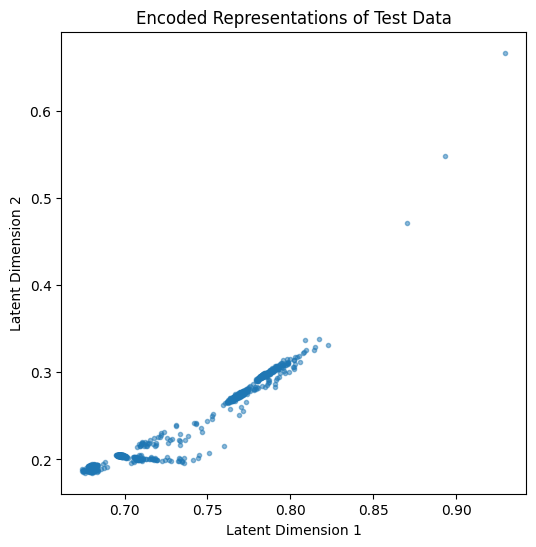

In [13]:
x_test_encoded = autoencoder.predict(x_test, batch_size=batch_size)

x_test_encoded = np.array(x_test_encoded)

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], marker='.', alpha=0.5, )
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Encoded Representations of Test Data')
plt.show()

In [14]:
x_test_encoded.shape

(1000, 49980)

In [23]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

x_test_flattened = x_test_encoded.reshape(1000, 140*119*3)
# x_test_flattened.shape

pca = PCA(n_components=200, random_state=22)
pca.fit(x_test_flattened)
x = pca.transform(x_test_flattened)

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(x)

groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

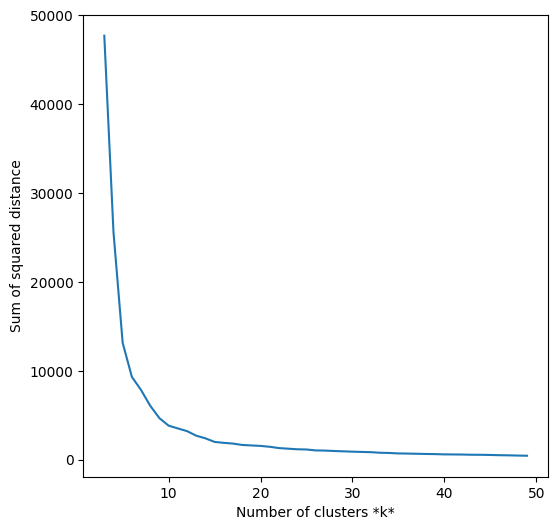

In [26]:
from PIL import Image


# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 50 images to be shown at a time
    if len(files) > 50:
        print(f"Clipping cluster size from {len(files)} to 50")
        files = files[:50]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = Image.open(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        
   
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

Clipping cluster size from 565 to 50


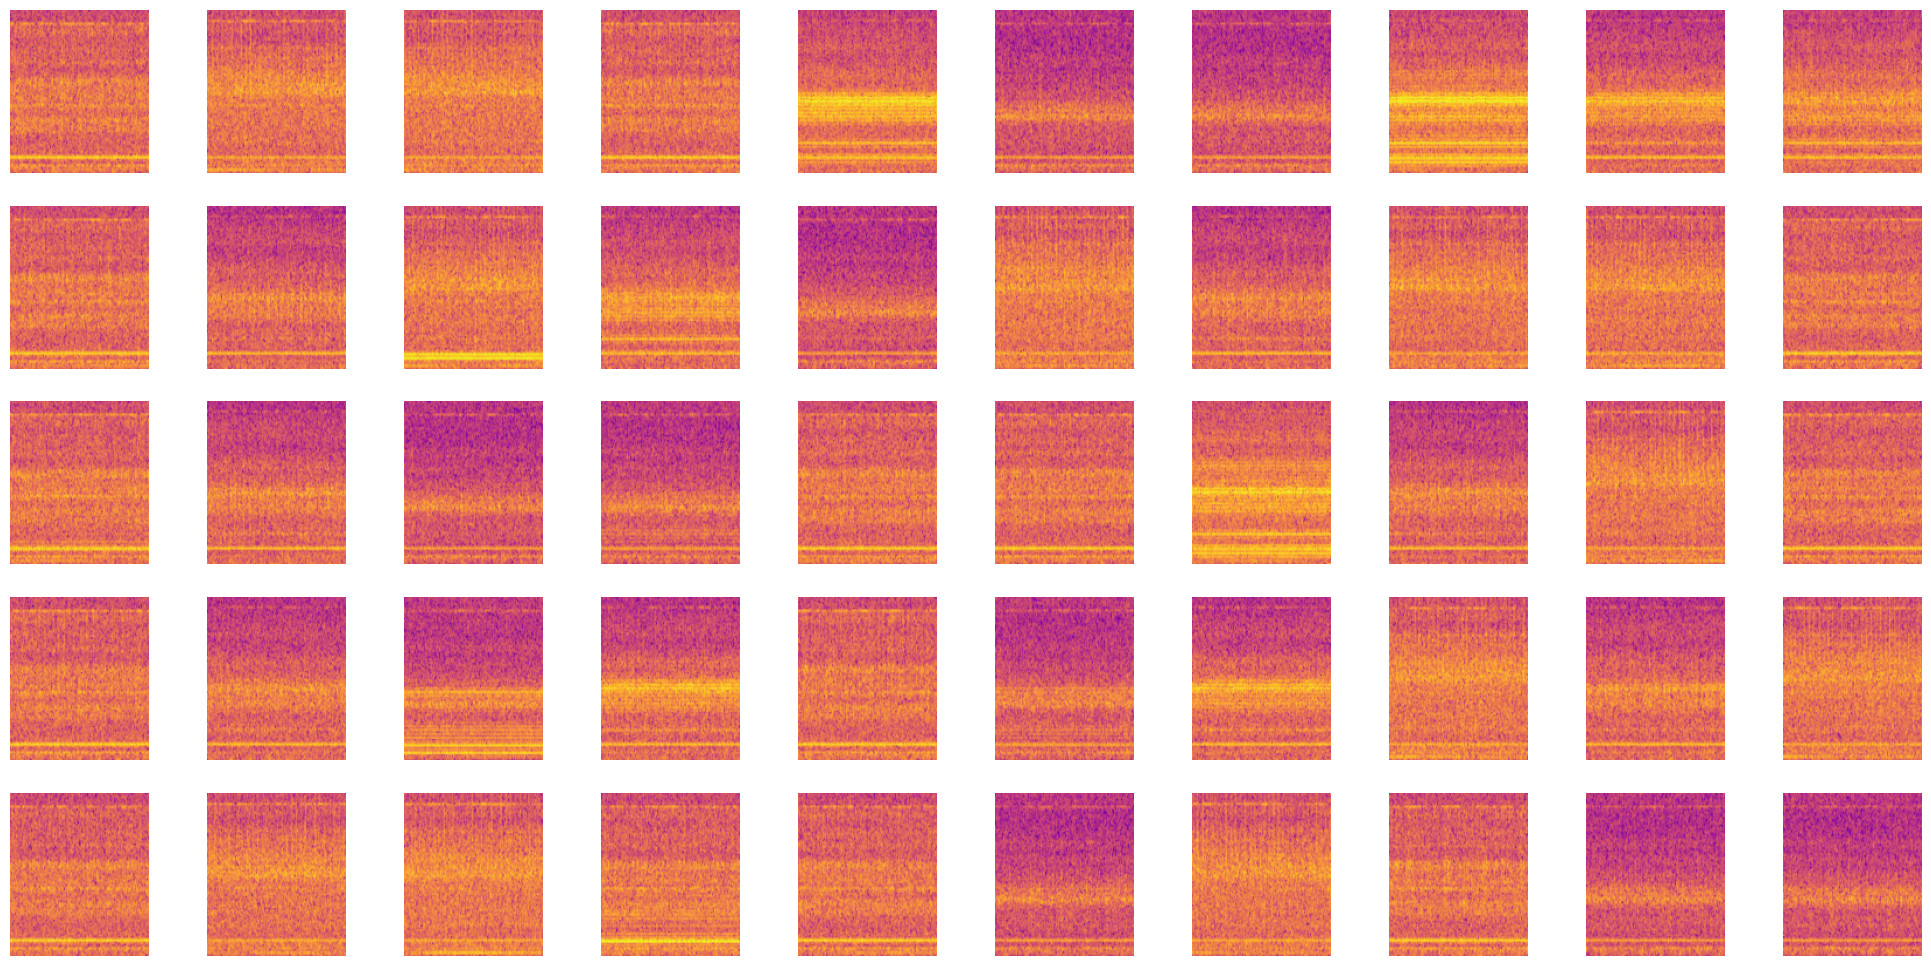

In [28]:
view_cluster(0)

32/32 [==============================] - 0s 8ms/step


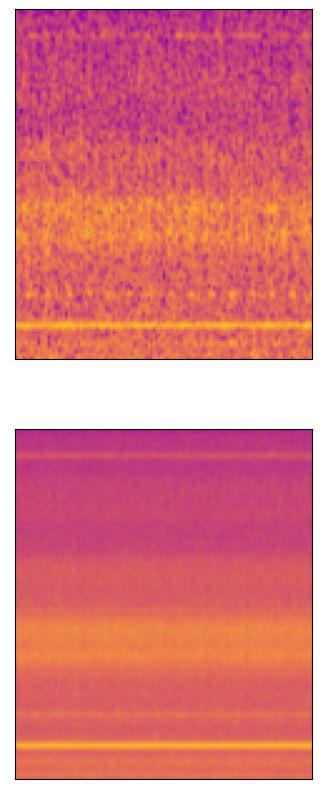

In [44]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

x = 543
n = 1  # How many digits we will display
plt.figure(figsize=(10, 10))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[x].reshape(140, 119, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[x].reshape(140, 119, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show();